# Imputation notebook

Contains:
1. libraries
2. data import
3. imputation quality experiment (leave one out)
4. create imputation models
5. create imputed dataframe

## 1. Libraries

In [1]:
import dill as pickle
import csv
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from unidecode import unidecode
import tensorflow as tf
from transformers import BertTokenizer
from evlex_shared_scripts import *
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# #
good_pos = {'NOUN','ADJ','VERB'}
excluded_lemmas = {'be', 'other', 'have', 'let', 'one', 'lot', 'same', 'such', 't', 's'}

2024-12-18 08:35:45.620915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 08:35:45.625764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 08:35:45.673962: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 08:35:45.710693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734528945.743710  315677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734528945.75

## 2. Data Import

In [2]:
# files
metadata = './files/doreco_files_metadata.csv'
corpus_fn = './files/corpus_doreco.p'
bert_indices = './files/indices.p'
bert_input_ids = './files/input_ids.p'
te_folder = './files/'
pickles_doc = './files'
doreco_bert_doc = './bert_vectors/'
prepared_vectors_doc = './bert_vectors/'

In [3]:
genres = {'personal narrative','traditional narrative','procedural', 'conversation'}
#
raw_corpus = pickle.load(open(corpus_fn, 'rb'))    
corpus = select_genres(raw_corpus, metadata, genres)
#
indices = pickle.load(open(bert_indices, 'rb'))
input_ids = pickle.load(open(bert_input_ids, 'rb'))

[('traditional narrative', 626), ('personal narrative', 436), ('stimulus retelling', 158), ('conversation', 108), ('procedural', 76), ('procedural/conversation', 2)]


2024-12-18 08:35:51.982537: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
def get_vectors(d, corpus):
    X, builder = np.zeros((0,768)), []
    #
    tes, te_words = pickle.load(open('%s/tes_%s.p' % (pickles_doc, d), 'rb'))
    #
    i_to_fl = [(f,l) for f in corpus[d] for l in corpus[d][f]]
    vectors = { f : np.load('%s/%s/%s.npy' % (doreco_bert_doc, d[:-4], f))[0] for f in corpus[d] }
    for te in tes:
        for mrk, te_idx in tes[te].items():
            for i in te_idx:
                file,line = i_to_fl[i]
                elt = corpus[d][file][line]
                text = next((e['text'] for e in elt['spc'] if unidecode(e['lemma']).lower() == te and 
                             (e['pos'] in good_pos and e['lemma'] not in excluded_lemmas and not is_actually_aux(e, elt['spc']))),None)
                if text == None: print(te, mrk, elt['ft'],'\n',elt['spc']); continue
                bert_target = tokenizer.encode(text)[1]
                bert_indices = np.where(np.array(indices[d][file]) == line)[0]
                bert_inputs  = np.array(input_ids[d][file])[0][bert_indices]
                bert_index = next((bix for j,bix in enumerate(bert_indices) if bert_inputs[j]== bert_target),None)
                # pad context left and right until certain length
                if bert_index == None: print('>>>', te,elt['ft']);   continue
                if len(X) % 500 == 0: print(d, len(X), te, mrk, bert_index, vectors[file][bert_index].shape)
                X = np.vstack([X, vectors[file][bert_index].reshape(1,-1)])
                builder.append({'term' : te, 'doculect' : d, 'file' : file, 'line' : line, 'marker' : mrk})
    np.save('%s/%s.npy' % (prepared_vectors_doc, d[:-4]), np.array(X))
    df = pd.DataFrame(builder)
    df.to_excel('%s/%s.xlsx' % (prepared_vectors_doc, d[:-4]))

In [5]:
regen_vectors = False
if regen_vectors:
    for d in corpus:
        get_vectors(d, corpus)

## 3. Imputation Quality Experiment

In [6]:
from sklearn.decomposition import TruncatedSVD as TSVD, PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sns

In [7]:
def load_data(doc, min_freq=5):
    df = pd.read_excel('%s/%s.xlsx' % (prepared_vectors_doc, doc[:-4]), na_filter=False)
    good_mrk = {mrk for mrk, ct in Counter(dict(list(df.value_counts('marker').items()))).items() if ct >= min_freq}
    X = np.load('%s/%s.npy' % (prepared_vectors_doc, doc[:-4]))[df.marker.isin(good_mrk)]
    df = df[df.marker.isin(good_mrk)]
    y = np.array([r.marker for i,r in df.iterrows()])
    return df, X, y

In [8]:
from datetime import datetime
datetime.now()

datetime.datetime(2024, 12, 18, 8, 35, 52, 459815)

In [10]:
from multiprocessing import Pool
classifier = SVC(kernel='linear', C = 0.05)
#classifier = MLPClassifier(hidden_layer_sizes=(250,), activation='tanh', max_iter=50)
# classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [ ]:
def parallelize_crossvalidation(doc, nfolds = 100, verbose=True):
    df,X,y = load_data(doc)
    accs = []
    for i,(tr,ts) in enumerate(KFold(n_splits=min(len(X),nfolds), shuffle=True, random_state=100).split(X), start = 1):
        classifier.fit(X[tr],y[tr])
        y_pred = classifier.predict(X[ts])
        accs.append(sum(y_pred==y[ts])/len(y[ts]))
        # for yi,yj in zip(y[ts], y_pred):
        #     per_obs[yi][yj] += 1
        #     per_pred[yj][yi] += 1
        if verbose and i % 25==0: print('\t',doc, i,len(X),len(y[ts]), accs[-1], np.mean(accs), datetime.now())
    print(doc, len(df), np.mean(accs))
    return np.mean(accs)

def get_baseline(doc):
    df = pd.read_excel('%s/%s.xlsx' % (prepared_vectors_doc,doc[:-4]), na_filter=False)
    correct = 0
    for term in df.term.unique():
        c = Counter(df[df.term == term].marker)
        correct += c.most_common(1)[0][1]
    return correct/len(df)

df_results = pd.DataFrame({'doculects' : sorted(corpus)})
with Pool(14) as p:
    df_results['accuracy'] = p.map(parallelize_crossvalidation, sorted(corpus))
df_results['baseline'] = [get_baseline(doc) for doc in sorted(corpus)]

	 cabe1245.csv 25 1250 13 0.9230769230769231 0.88 2024-12-18 07:33:05.266879
	 cabe1245.csv 50 1250 13 1.0 0.8892307692307692 2024-12-18 07:33:14.290498
	 hoch1243.csv 25 1618 16 0.875 0.7785294117647058 2024-12-18 07:33:16.752055
	 jeha1242.csv 25 2007 20 1.0 0.9214285714285714 2024-12-18 07:33:20.606660
	 cabe1245.csv 75 1250 12 1.0 0.8928205128205129 2024-12-18 07:33:25.582997
	 cabe1245.csv 100 1250 12 0.8333333333333334 0.882948717948718 2024-12-18 07:33:37.668135
cabe1245.csv 1250 0.882948717948718
	 hoch1243.csv 50 1618 16 0.6875 0.778014705882353 2024-12-18 07:33:38.349510
	 apah1238.csv 25 2708 27 0.8148148148148148 0.7803174603174604 2024-12-18 07:33:45.684912
	 jeha1242.csv 50 2007 20 0.85 0.9077142857142857 2024-12-18 07:33:46.930275
	 jeju1234.csv 25 1301 13 0.6153846153846154 0.776043956043956 2024-12-18 07:33:54.738177
	 even1259.csv 25 3125 32 0.78125 0.86625 2024-12-18 07:33:56.761578
	 hoch1243.csv 75 1618 16 0.75 0.7845098039215687 2024-12-18 07:34:00.598761
	 cash12

In [28]:
df_results

,doculects,accuracy,baseline
0,anal1239.csv,0.814194,0.602101
1,apah1238.csv,0.783968,0.643549
2,arap1274.csv,0.870166,0.667438
3,bain1259.csv,0.840434,0.679024
4,beja1238.csv,0.782710,0.606739
5,bora1263.csv,0.782678,0.600044
6,cabe1245.csv,0.882949,0.751055
7,cash1254.csv,0.841280,0.653905
8,dolg1241.csv,0.888194,0.735083
9,even1259.csv,0.869788,0.710405


0.855761825986452 0.7162141390934019


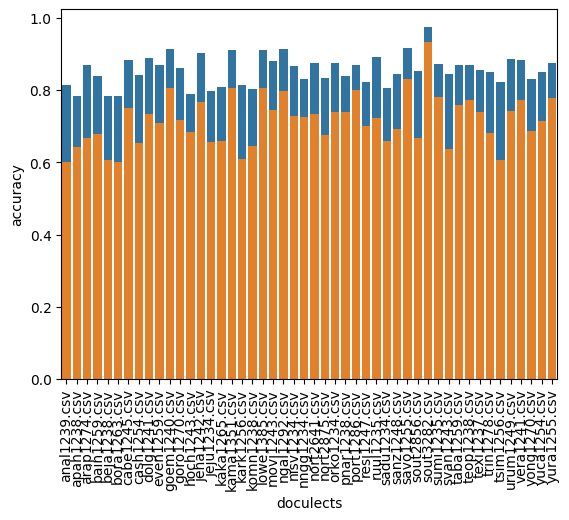

In [29]:
from matplotlib import pyplot as plt
print(np.mean(df_results.accuracy), np.mean(df_results.baseline))
sns.barplot(data=df_results, x='doculects', y='accuracy')
sns.barplot(data=df_results, x='doculects', y='baseline')
x = plt.xticks(rotation=90)

## 4. create models for each doculect

In [11]:
regenerate_classification_models = True
if regenerate_classification_models:
    for doc in corpus:
        df, X, y = load_data(doc)
        classifier.fit(X,y)
        pickle.dump(classifier, open('%s/model_%s.p' % (te_folder, doc[:-4]), 'wb'))
        print(doc)

anal1239.csv
apah1238.csv
arap1274.csv
bain1259.csv
beja1238.csv
bora1263.csv
cabe1245.csv
cash1254.csv
dolg1241.csv
even1259.csv
goem1240.csv
goro1270.csv
hoch1243.csv
jeha1242.csv
jeju1234.csv
kaka1265.csv
kama1351.csv
kark1256.csv
komn1238.csv
lowe1385.csv
movi1243.csv
ngal1292.csv
nisv1234.csv
nngg1234.csv
nort2641.csv
nort2875.csv
orko1234.csv
pnar1238.csv
port1286.csv
resi1247.csv
ruul1235.csv
sadu1234.csv
sanz1248.csv
savo1255.csv
sout2856.csv
sout3282.csv
sumi1235.csv
svan1243.csv
taba1259.csv
teop1238.csv
texi1237.csv
trin1278.csv
tsim1256.csv
urum1249.csv
vera1241.csv
yong1270.csv
yuca1254.csv
yura1255.csv


## 5. create imputed dataframe

In [12]:
def get_offset_ft(corpus, doc, file, line, offset):
    line_fields = line.split('_')
    ln = ('%04d' % (int(line_fields[0]) + offset)) + '_' + '_'.join(line_fields[1:])
    try: return corpus[doc][file][ln]['ft']
    except KeyError: return '' 

imputed_data_builder = []
for doc in corpus:
    print(doc[:4], end =' ')
    df_doc, X, y = load_data(doc)
    df_doc['doculect'] = [doc[:-4]] * len(df_doc)
    Fm, F, Fp, T, G, M = zip(*[(
        get_offset_ft(corpus, doc, file, line, -1), corpus[doc][file][line]['ft'],
        get_offset_ft(corpus, doc, file, line, +1), corpus[doc][file][line]['tx'], 
        ' '.join('.'.join(m['G']) for m in corpus[doc][file][line]['gloss']),
        ' '.join('.'.join(m['M']) for m in corpus[doc][file][line]['gloss']))
                               for file,line in zip(df_doc.file, df_doc.line)])
    df_doc['ft-1'], df_doc['ft'], df_doc['ft+1'] = Fm, F, Fp
    df_doc['tx'], df_doc['gl'], df_doc['mr'] = T, G, M
    imputed_data_builder.append(df_doc)
imputed_data = pd.concat(imputed_data_builder)

anal apah arap bain beja bora cabe cash dolg even goem goro hoch jeha jeju kaka kama kark komn lowe movi ngal nisv nngg nort nort orko pnar port resi ruul sadu sanz savo sout sout sumi svan taba teop texi trin tsim urum vera yong yuca yura 

In [13]:
imputed_data.sample(30)

,Unnamed: 0,term,doculect,file,line,marker,ft-1,ft,ft+1,tx,gl,mr
3192,3192,water,trin1278,doreco_trin1278_T06,0028_DoReCo_doreco_trin1278_T06,^une$,"""Come, fish, do me a favor and free me of thes...",And it is said that all the fish that were in ...,And the jaguar was just about to die.,ene to tavechtikporipuiji tamutaeji to jimono ...,and ART.NH 3NH.let.loose.ACT.PROG.GRAD.RPT 3NH...,ene to ta-.vechti.-k.=poripu.=iji ta-.muta.=ej...
1921,1921,village,vera1241,doreco_vera1241_veraa_iswm,0048_DoReCo_doreco_vera1241_veraa_iswm,^sara$,All the time when they stayed there they looked.,"The kids played on the village square, and whe...","That light or what down there, what is it?",'eraga m̄ērm̄ērek 'oror lēn sara dirēk kal...,,
2987,2987,father,kaka1265,doreco_kaka1265_kke-c_2013-12-07_talk-05,0005_DoReCo_doreco_kaka1265_kke-c_2013-12-07_t...,^baaba,Is your mother there?,Is your father there?,Where are you from?,i bàaba i ɲɔ́ɔ,2SG father be that,i bàaba bi ɲɔ́ɔ
1399,1399,devil,vera1241,doreco_vera1241_veraa_palab,0098_DoReCo_doreco_vera1241_veraa_palab,^'ama,and the younger one threw another leaf again.,And this panundas leaf came and pierced the de...,"He went upwards to do something about it, i . ...",e dudu vada 'anē'ē ne van s ne van ma anē n...,CC leaf pandanas DEM1.A TAM2.3SG go TAM2.3SG ...,e dudu vada anē'ē ne van ne van ma anē ne ...
5122,5122,grab,sout2856,doreco_sout2856_105,0031_DoReCo_doreco_sout2856_105,^makou$,"the small heron was looking around, it didn't ...","It went, it stood straight in the hole of the ...","When it walked straight in the crab's hole, th...",105-031 ipan ipalag leg ki nfal ni nana makou ...,3S.RS.go 3S.RS.stand be.straight PREP hole of...,i=.pan i=.paalag leg ki nfal ni nana makou me...
3413,3413,buy,kaka1265,doreco_kaka1265_kke-c_2013-12-07_talk-01,0218_DoReCo_doreco_kaka1265_kke-c_2013-12-07_t...,^san,"He had no money,",to buy a bicycle for me.,"Yes, a bycicle.",min saa kɛɛ an ni vèló sàn ɲɲe,which POT 3SG this 3PL OPT ETRG.FR buy 1SG.for,min si a kɛɛ anu ni vèló sàn n.yen
477,477,say,goro1270,doreco_goro1270_20151125i,0589_DoReCo_doreco_goro1270_20151125i,^oo,he didn't cry out,"he said, if (my) children are gone, who will I...","my children are dead, I pity them",aqo ina oó bara na/a i kahhiyá aní heé ni gurtlâw,Aux S.3.Aux.Imprf say if.S.3.Aux.Prf children....,∅.=qo i-.∅.-na oo'.´ bar-.i-.∅.-(g)a na/a'.~´~...
6838,6838,cassava,bora1263,doreco_bora1263_ovehe_1,0049_DoReCo_doreco_bora1263_ovehe_1,^caatso,"When her husband returned from the hunting, he...","What do you spend doing, why don't you get cas...",And the cassava that tried to get was very lit...,aca ɨɨná ú méénuhíjcyá ɨ́veekí tsá u cáátsotú ...,Q.doubt what 2SG do.REP why no 2SG grate.NEG w...,aca ɨɨ́ne u meenu.-híjcya ɨ́veeki tsáha u caát...
2011,2011,return,goro1270,doreco_goro1270_20151202e,0065_DoReCo_doreco_goro1270_20151202e,atl,six months were finished down there,"when six months had ended, the people returned",they had already been taught,slehheerí lehhó birna faakí iimi nina wátl,six if.Aux3.if.Imprf finish people AuxVent.I...,lehhó b-.i.-r.=na faák.-í' iimi ni.=na wátl
2565,2565,white,apah1238,doreco_apah1238_TGB_Kris_Daud_13-2,0147_DoReCo_doreco_apah1238_TGB_Kris_Daud_13-2,^yanggo,"eh, white",its shape is like a door and it is white,is there one like that or not?,sok hag toho seg lit te yanggoreg,door like do.ADV.PART DONE CONJ then white.ABL,sok hag tu.-oho seg lit te yanggo.-teg


In [14]:
ft_per_m = {}
for doci in corpus:
    print('load ft_per_m for %s' % doci[:-4])
    dfi, Xi, yi = load_data(doci)
    ft_per_m[doci] = {}
    for marker in dfi.marker.unique():
        ft_per_m[doci][marker] = set(dfi[dfi.marker == marker].term.unique())

load ft_per_m for anal1239
load ft_per_m for apah1238
load ft_per_m for arap1274
load ft_per_m for bain1259
load ft_per_m for beja1238
load ft_per_m for bora1263
load ft_per_m for cabe1245
load ft_per_m for cash1254
load ft_per_m for dolg1241
load ft_per_m for even1259
load ft_per_m for goem1240
load ft_per_m for goro1270
load ft_per_m for hoch1243
load ft_per_m for jeha1242
load ft_per_m for jeju1234
load ft_per_m for kaka1265
load ft_per_m for kama1351
load ft_per_m for kark1256
load ft_per_m for komn1238
load ft_per_m for lowe1385
load ft_per_m for movi1243
load ft_per_m for ngal1292
load ft_per_m for nisv1234
load ft_per_m for nngg1234
load ft_per_m for nort2641
load ft_per_m for nort2875
load ft_per_m for orko1234
load ft_per_m for pnar1238
load ft_per_m for port1286
load ft_per_m for resi1247
load ft_per_m for ruul1235
load ft_per_m for sadu1234
load ft_per_m for sanz1248
load ft_per_m for savo1255
load ft_per_m for sout2856
load ft_per_m for sout3282
load ft_per_m for sumi1235
l

In [15]:
def parallelize_imputation(doci):
    classifier = pickle.load(open('%s/model_%s.p' % (te_folder, doci[:-4]), 'rb'))
    dfi, Xi, yi = load_data(doci)
    ft_doci = set(dfi.term.unique())
    #
    imputed_terms, ft_present = [],[]
    for docj in corpus:
        print('  %s -- %s' % (doci[:-4], docj[:-4]), datetime.now())
        if docj == doci: 
            imputed_terms.extend(yi)
            ft_present.extend([True]*len(yi))
        else:
            dfj, Xj, yj = load_data(docj)
            y_pred = classifier.predict(Xj)
            imputed_terms.extend(y_pred)
            ft_present.extend([ft_per_m[docj][marker] & ft_doci != set() for marker in dfj.marker])
    #imputed_data['imputed_%s' % doci[:-4]] = imputed_terms
    #imputed_data['ft_present_%s' % doci[:-4]] = ft_present
    print(doci, len(imputed_terms), len(ft_present))
    return imputed_terms, ft_present

In [16]:
from datetime import datetime
from multiprocessing import Pool
with Pool(14) as p:
    results = p.map(parallelize_imputation, sorted(corpus))

  cabe1245 -- anal1239 2024-12-18 08:41:19.698644
  hoch1243 -- anal1239 2024-12-18 08:41:19.835194
  jeha1242 -- anal1239 2024-12-18 08:41:19.888767
  apah1238 -- anal1239 2024-12-18 08:41:20.183281
  arap1274 -- anal1239 2024-12-18 08:41:20.218203
  even1259 -- anal1239 2024-12-18 08:41:20.275869
  cash1254 -- anal1239 2024-12-18 08:41:20.291639
  bain1259 -- anal1239 2024-12-18 08:41:20.384842
  anal1239 -- anal1239 2024-12-18 08:41:20.405410
  anal1239 -- apah1238 2024-12-18 08:41:20.422073
  goro1270 -- anal1239 2024-12-18 08:41:20.803528
  dolg1241 -- anal1239 2024-12-18 08:41:24.579632
  beja1238 -- anal1239 2024-12-18 08:41:24.627171
  goem1240 -- anal1239 2024-12-18 08:41:24.868711
  bora1263 -- anal1239 2024-12-18 08:41:25.696954
  cabe1245 -- apah1238 2024-12-18 08:41:26.938131
  hoch1243 -- apah1238 2024-12-18 08:41:30.071544
  cabe1245 -- arap1274 2024-12-18 08:41:30.697247
  jeha1242 -- apah1238 2024-12-18 08:41:33.309063
  cabe1245 -- bain1259 2024-12-18 08:41:34.521667


In [17]:
for doc,(it,ft) in zip(sorted(corpus),results):
    imputed_data['imputed_%s' % doc[:-4]] = it
    imputed_data['ft_present_%s' % doc[:-4]] = ft

/tmp/ipykernel_315677/617767790.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imputed_data['imputed_%s' % doc[:-4]] = it
/tmp/ipykernel_315677/617767790.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imputed_data['ft_present_%s' % doc[:-4]] = ft
/tmp/ipykernel_315677/617767790.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [18]:
imputed_data.to_excel('%s/imputed_data.xlsx' % (te_folder))

In [19]:
imputed_data.columns

Index(['Unnamed: 0', 'term', 'doculect', 'file', 'line', 'marker', 'ft-1',
       'ft', 'ft+1', 'tx',
       ...
       'imputed_urum1249', 'ft_present_urum1249', 'imputed_vera1241',
       'ft_present_vera1241', 'imputed_yong1270', 'ft_present_yong1270',
       'imputed_yuca1254', 'ft_present_yuca1254', 'imputed_yura1255',
       'ft_present_yura1255'],
      dtype='object', length=108)

In [20]:
imputed_data.sample(10)

,Unnamed: 0,term,doculect,file,line,marker,ft-1,ft,ft+1,tx,...,imputed_urum1249,ft_present_urum1249,imputed_vera1241,ft_present_vera1241,imputed_yong1270,ft_present_yong1270,imputed_yuca1254,ft_present_yuca1254,imputed_yura1255,ft_present_yura1255
2716,2716,pass,ruul1235,doreco_ruul1235_ll-R-NAKASONGOLA-170225-FS-1b,0266_DoReCo_doreco_ruul1235_ll-R-NAKASONGOLA-1...,kala,So with that . . . Go and memorise that today.,Are you planning to pass by your parent's home,and take for them (some thing).,okuteːkateːka kwaːkalajo,...,^gec,True,^den$,False,^sw-ha$,True,^maan,True,ani,False
2106,2106,finish,teop1238,doreco_teop1238_Nan_03,0077_DoReCo_doreco_teop1238_Nan_03,kavara,"His mother was working,","getting food, but he was finishing his basket.","And (he) finished his basket, and finished his...",gono taba an nana evehee vaakavakavara nana bo...,...,^gurt,True,^qe'$,True,-se,True,'ik,False,sham,False
3233,3233,full,movi1243,doreco_movi1243_escape_de_la_hija,0116_DoReCo_doreco_movi1243_escape_de_la_hija,^jem,'We changed her clothes.','Then she showed me her dress full of mud.','And her legs had got scratched here in the wi...,jayna chuspa:kayisne noj do'we'ne jémbu'un,...,^ustumuzdan$,False,^wor,False,^sidzi-thaeqo$,False,^yiik'al$,False,sham,False
4871,4871,forget,sout2856,doreco_sout2856_120_cut,0008_DoReCo_doreco_sout2856_120_cut,metpak,we didn't do any work. They were the ones who ...,"but we were young and not very wise, we got so...",Which meant that we couldn't get it. But some ...,me welkia namroan nigmam teesa isees usat tete...,...,^unu,True,^serege$,False,^thi-tcw-ni-tsw$,False,sa'a,False,dyuj,False
1750,1750,tell,bora1263,doreco_bora1263_llijchu_ine_I,0168_DoReCo_doreco_bora1263_llijchu_ine_I,uballe,Then he told him.,So because they have told him he paid by putti...,His dad's ampiri has made his heads.,ehdu ditye úúbálléne áhdó diityéké nuwááñuíñuu...,...,^de,True,'aram$,True,zwu,True,^ya'al,True,^kut,True
2085,2085,true,yong1270,doreco_yong1270_crdo-NRU_F4_BURIEDALIVE3,0093_DoReCo_doreco_yong1270_crdo-NRU_F4_BURIED...,^gw-,"""Don't say she's not dead! / I prohibit you fr...","So the young man continued:"" [But if,] true, f...","So, as she said that three days had already sp...",tʰi˩˥ | gɯ˩-ʝi˥-dʑo˩ | gɯ˩-ʝi˥ | mɤ˧-ʂɯ˧ | pi˧...,...,^die,False,^ror$,True,^gw-,True,^jaaj$,True,yita,False
12075,12075,long,kama1351,doreco_kama1351_PKZ_196X_FoxAndCrane_flk,0006_DoReCo_doreco_kama1351_PKZ_196X_FoxAndCra...,^numo,He himself is eating but [the crane] cannot eat.,"His nose is long, he could not.",Then he says:,dĭn püjet no u numo ej mobi,...,^boyuk,False,luwo$,False,sae-,True,^noj,False,sham,False
4423,4423,feather,cash1254,doreco_cash1254_GN_Yube_xenidan,0407_DoReCo_doreco_cash1254_GN_Yube_xenidan,^nea$,She found the little catfish that was inserted...,She plucked out all the trumpeter bird feather...,"""I don't get the little catfish,",hawen nea dani maiti daki mexan keyunkin bida,...,^balkalari$,False,^sisidin$,True,^mu-gu-ze$,False,'ik,False,^ashans,False
3822,3822,man,nngg1234,doreco_nngg1234_NM071022-01aA,0364_DoReCo_doreco_nngg1234_NM071022-01aA,^|=xai,the kids,the young man,hy plays...,ǂxai,...,^adam,True,lumgav$,True,^zo,True,^maak,True,hunn,True
2481,2481,obstinate,ruul1235,doreco_ruul1235_ll-R-NAKASONGOLA-190801-FS-2,0511_DoReCo_doreco_ruul1235_ll-R-NAKASONGOLA-1...,^kaboko$,And greed.,Why is an obstinate person and a greedy person...,,owa kaboko oni nowa nowa kadoko lwaːki teβakwi...,...,^catin,False,^ror$,False,^mu-gu-ze$,False,tuut,False,^yanore$,False


# clustering

In [56]:
import pandas as pd
imputed_data = pd.read_excel('./pickles/imputed_data.xlsx')


KeyboardInterrupt



In [ ]:
imputed_data.head()

In [14]:
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx
import dill as pickle
from datetime import datetime 
regenerate_graph = False

if regenerate_graph:
    #
    cols = [c for c in imputed_data.columns if c.startswith('imputed')]
    val_dict = {}
    for c in cols:
        for t in imputed_data[c].unique():
            if not isinstance(t,str): print(t); continue
            val_dict[c,t] = len(val_dict)
    R,C = [], []
    for i,r in imputed_data.iterrows():
        col_vals = [val_dict[c,r[c]] for c in cols if (c,r[c]) in val_dict]
        R.extend([i]*len(col_vals))
        C.extend(col_vals)
    sparse_matrix = csr_matrix((np.ones(len(R)), (R, C)), dtype=np.int16)
    #
    block = 5000
    min_score = 44
    edges = []
    for i in range(0,sparse_matrix.shape[0],block):
        affinity = sparse_matrix[i:i+block].dot(sparse_matrix[i:].T) >= min_score
        for x,y in zip(*affinity.nonzero()):
            if x < y:
                edges.append((x+i,y+i))
        print(s, i, '%.3f%%' % (100*affinity.nnz/(affinity.shape[0]*affinity.shape[1])), len(edges), datetime.now())
    G = nx.Graph()
    G.add_nodes_from(range(sparse_matrix.shape[0]))
    G.add_edges_from(edges)
    pickle.dump(G, open('graph.p', 'wb'))
else: G = pickle.load(open('graph.p', 'rb'))

In [62]:
def get_best_ci(Gi, min_c):
    best_ci = []
    for ci in nx.find_cliques(Gi):
        if len(ci) >= max(min_c, len(best_ci)):
            best_ci = ci
    return best_ci

start = datetime.now()
min_c = 10
cliques = []
for i,c in enumerate(filter(lambda c : len(c) >= min_c, nx.connected_components(G))):
    Gi = G.subgraph(c)
    good_nodes = {k for k,v in Gi.degree if v >= min_c}
    print(len(c), len(good_nodes))
    Gi = Gi.subgraph(good_nodes)
    best_ci = get_best_ci(Gi, min_c)
    while best_ci != []:
        cliques.append(best_ci)
        Gi = Gi.subgraph(set(Gi.nodes()) - set(best_ci))
        good_nodes = {k for k,v in Gi.degree if v >= min_c}
        Gi = Gi.subgraph(good_nodes)   
        best_ci = get_best_ci(Gi, min_c)
    print(i, len(c), len(cliques))

from collections import Counter
print(Counter([len(c) for c in cliques]))
print(datetime.now() - start)

7800 7165
0 7800 118
874 361
1 874 123
1777 700
2 1777 135
47 0
3 47 135
97 15
4 97 135
361 112
5 361 137
3914 2330
6 3914 178
936 838
7 936 198
1824 1511
8 1824 232
608 137
9 608 235
1522 1381
10 1522 260
384 209
11 384 264
461 155
12 461 266
10 0
13 10 266
741 592
14 741 280
492 285
15 492 287
244 58
16 244 288
1224 715
17 1224 301
54 3
18 54 301
44 6
19 44 301
2066 1907
20 2066 326
18 0
21 18 326
51 7
22 51 326
76 2
23 76 326
334 109
24 334 328
56 4
25 56 328
482 185
26 482 331
1007 979
27 1007 349
673 619
28 673 365
251 50
29 251 365
10 0
30 10 365
97 9
31 97 365
1703 1370
32 1703 396
183 38
33 183 397
119 90
34 119 399
341 242
35 341 405
375 87
36 375 406
666 632
37 666 421
120 26
38 120 422
325 194
39 325 425
689 411
40 689 436
142 49
41 142 437
50 2
42 50 437
307 238
43 307 444
1021 820
44 1021 460
51 17
45 51 460
265 97
46 265 461
40 2
47 40 461
1648 1479
48 1648 497
1203 1066
49 1203 513
269 101
50 269 514
589 139
51 589 516
41 8
52 41 516
12 0
53 12 516
201 67
54 201 517
1062

In [65]:
Counter([len(c) for c in cliques])

Counter({11: 70,
         10: 60,
         13: 50,
         12: 49,
         14: 36,
         15: 27,
         18: 25,
         16: 25,
         17: 24,
         20: 19,
         19: 14,
         24: 13,
         22: 12,
         25: 11,
         21: 11,
         28: 10,
         23: 10,
         26: 9,
         38: 7,
         37: 7,
         34: 7,
         32: 7,
         31: 7,
         42: 6,
         27: 6,
         33: 5,
         49: 4,
         30: 4,
         44: 4,
         45: 4,
         48: 3,
         40: 3,
         29: 3,
         107: 2,
         98: 2,
         51: 2,
         46: 2,
         56: 2,
         36: 2,
         68: 2,
         100: 2,
         71: 2,
         76: 2,
         58: 2,
         78: 2,
         775: 1,
         577: 1,
         215: 1,
         190: 1,
         163: 1,
         117: 1,
         104: 1,
         96: 1,
         93: 1,
         84: 1,
         75: 1,
         72: 1,
         64: 1,
         62: 1,
         53: 1,
         50: 1

In [64]:
pickle.dump(cliques, open('cliques_%s.p' % min_c, 'wb'))

# OLD

In [ ]:
term_extensions = defaultdict(lambda : {})
for c,m in imputed_values.items():
    for l in m.columns[1:]:
        for t in m[l].unique():
            if isinstance(t,str):
                term_extensions[l,t][c] = m[l] == t

In [ ]:
for l,t in list(term_extensions):
    polyseme_graph = nx.Graph()
    polyseme_graph.add_nodes_from(term_extensions[l,t].keys())
    for e1,e2 in combinations(sorted(term_extensions[l,t]),2):
        if len(colexification_pairs[e1,e2]) > 1:
            polyseme_graph.add_edge(e1,e2)
    if nx.number_connected_components(polyseme_graph) == 1: continue
    for ci,c in enumerate(nx.connected_components(polyseme_graph)):
        for cx in c:
            term_extensions[l,t + '-' + str(ci+1)][cx] = term_extensions[l,t][cx]
    del term_extensions[l,t]
            

In [ ]:
print(len(term_extensionstensions))

In [ ]:
np.set_printoptions(precision=2)
strip_index = lambda k : k.split('-')[0]
model = {}
for l,t in sorted(term_extensions):
    df = pd.concat([imputed_values[c][term_extensions[l,t][c]] for c in term_extensions[l,t]])
    #if len(term_extensions[l,t]) == 1: continue
    df_long = short_to_long(df[df.columns[1:]]) 
    try:
        model[l,t] = {'pca' : PCA()}
        model[l,t]['coo'] = model[l,t]['pca'].fit_transform(df_long.to_numpy())
        good_pc = next((i for i,e in enumerate(model[l,t]['pca'].explained_variance_) if e < 1),0)
        if good_pc == 0:
            del model[l,t]
            continue
        model[l,t]['coo'] = model[l,t]['coo'][:,:max(2,good_pc)]
        print(l,t,list(term_extensions[l,t]), len(df), good_pc)
    except: continue
pickle.dump(model, open('pca_models.p','wb'))

In [ ]:
print(len(model))
print(Counter([sum(v['pca'].explained_variance_ >= 1) for v in model.values()]))

In [ ]:
corpus_size = {d : sum(len(ei) for ei in bitexts[d][1]) for d in bitexts}

In [ ]:
conc_data = pd.read_excel('../metaphor/bert_exploration/13428_2013_403_MOESM1_ESM.xlsx')
conc_dict = {r.Word : r['Conc.M'] for i,r in conc_data.iterrows()}

In [ ]:
def colex(coo_h, terms_h, k=3):
    ordered = coo_h.argsort()
    return int(Counter(terms_h[ordered[:k]]).most_common(1)[0][0] == 
               Counter(terms_h[ordered[len(ordered)-k:]]).most_common(1)[0][0])

In [ ]:
builder = []
for (l,t) in sorted(model):
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(coo)
    n_good_dims = sum(pca.explained_variance_ >= 1)
    #print(l.upper(), t.upper(), '\t', n_good_dims, pca.explained_variance_[:5], pca.explained_variance_ratio_[:5])
    good_docs = [d for d,v in df_orig.value_counts('doculect').items() if v >= 10]
    wpms = {d : np.log(1e6*sum(df_orig.doculect==d)/corpus_size[d]) for d in good_docs}
    wpm_m, wpm_s = np.mean(list(wpms.values())), np.std(list(wpms.values()))
    #
    for dim in range(n_good_dims):
        hits = {d : (df_orig.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        #skew_dir = -1 if skew(coo[:,dim]) < 0 else 1
        #mean_dir = -1 if np.mean(np.mean(coo[df.doculect==d,dim]) for d in good_docs_d) < 0 else 1
        
        print('  DIM %d: N bad docs = %d, N good docs = %d' % 
              (dim, len(good_docs)-len(good_docs_d), len(good_docs_d)))
        indeps = {}
#         indeps['spread_mean'] = { d : abs(np.mean(coo_scaled[hits[d],dim])) for d in good_docs_d}
        indeps['spread_sd'] = { d : np.std(coo_scaled[hits[d],dim]) for d in good_docs_d }
#         indeps['spread_skew'] = { d : abs(skew(coo[hits[d],dim])) for d in good_docs_d }
#         indeps['spread_kurtosis'] = { d : kurtosis(coo[hits[d],dim]) for d in good_docs_d }
        #
        ms = {k : (np.mean(list(v.values())), np.std(list(v.values()))) for k,v in indeps.items()}
        
        for doc in sorted(good_docs_d):
            h = (df_orig.doculect==doc).to_numpy()
            if len(df_orig[h].term.unique()) == 1: IG, IGR = 0, 0
            else:
                d = DecisionTreeClassifier(max_depth=1,criterion="entropy")
                d.fit(coo[h,dim].reshape(-1,1), df_orig[h].term)
                H_start = d.tree_.impurity[0]
                p_left = sum(coo[h,dim] < d.tree_.threshold[0])/sum(h)
                H_new = (p_left * d.tree_.impurity[1]) + ((1-p_left) * d.tree_.impurity[2])
                IG = H_start - H_new
                IGR = IG/H_start
            #            
            builder.append({'term' : t, 'orig_doculect' : l,
                            'doculect' : doc, 'PC' : dim, 'IG' : IG, 'IGR' : IGR,
                            'nTermTypes' : len(df_orig[h].term.unique()), 'nTermTokens' : sum(h),
                            'nFieldTypes' : len(terms),
                            'wpm' : wpms[doc], 'wpm_z' : (wpms[doc]-wpm_m)/wpm_s,
                            'concreteness' : conc_score, 'ev' : pca.explained_variance_[dim],
                            'colexifies_1' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=1),
                            'colexifies_3' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=3),
                            'colexifies_5' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=5)})
            for k in indeps:
                builder[-1][k] = indeps[k][doc]#(indeps[k][doc]-ms[k][0])/ms[k][1]

In [ ]:
from scipy.stats import pearsonr
from itertools import product
from scipy.stats.mstats import zscore

import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from statsmodels.graphics.api import interaction_plot, abline_plot

In [ ]:
X = [ 'spread_sd', 'wpm', 'concreteness']
Y = ['IG','colexifies_3']
df_result = pd.DataFrame(builder)
for v in X+Y[:1]: df_result[v] = zscore(df_result[v])

In [ ]:
sns.heatmap(df_result[X].corr(), cmap='vlag', vmin=-1, vmax=1, annot=True);

In [ ]:
dfi = df_result#[df_result.nFieldTypes>1]
y = 'colexifies_3'
print(dfi.value_counts(y))
lm = logit('%s ~  spread_sd + wpm + concreteness' % y, dfi).fit()
print(lm.summary())

In [ ]:
# manual example of dealing with odds ratios
sd = 0
z = -0.2 + (sd * -0.59) #+ (sk * 1.06)
p = 1 / (1 + np.exp(-z))
print(p)

In [ ]:
from scipy.stats import ttest_ind
dataslices = {'all' : df_result, 
              'pc0' : df_result[df_result.PC == 0]}
y = 'colexifies_3'
for x in X + ['nFieldTypes']:
    for k,dfi in dataslices.items():
        t,p = ttest_ind(dfi[dfi[y]==0][x], dfi[dfi[y]==1][x])
        print('%s~%s for %s: t=%.3f, p=%.3f' % (y,x,k, t,p))
        sns.boxplot(data=dfi, x = y, y = x)
        plt.show()

In [ ]:
dfi = df_result
lm = ols('IG ~ spread_sd + wpm + concreteness', dfi).fit()
print(lm.summary())

In [ ]:
dataslices = {'all' : df_result, 
              'pc0' : df_result[df_result.PC == 0], 'pc+' : df_result[df_result.PC != 0]}
y = 'IG'
for x in X + ['nFieldTypes']:
    for k,dfi in dataslices.items():
        if k != 'all': continue
        r,p = pearsonr(dfi[x], dfi[y])
        print('%s~%s for %s: r=%.3f, p=%.3f' % (y,x,k, r,p))
        sns.regplot(data=dfi, x = x, y = y, scatter_kws={'s':10,'color':'#606060'}, line_kws={'lw':3,'color':'r'})
        plt.show()

In [ ]:
for (l,t) in model:
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    n_good_dims = sum(pca.explained_variance_ >= 1)
    good_docs = [d for d,v in Counter(dict(df_orig.value_counts('doculect'))).items() if v >= 10]
    #
    nrows = max(1,(len(good_docs)+3)//4)
    for dim in range(n_good_dims):
        print('\t', dim)
        plt.figure(figsize=(35,8*nrows))
        fig, axs = plt.subplots(nrows=nrows, ncols=4, squeeze=False, sharex=True, sharey=True, figsize=(30,7*nrows))
        #fig.title('%s; PC%d' % (ts, dim+1))
        hits = {d : (df_orig.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        #
        for i,doc in enumerate(good_docs):
            b = next((b for b in builder if b['term'] == t and b['orig_doculect'] == l and b['doculect'] == doc),None)
            h = (df_orig.doculect==doc).to_numpy()
            if sum(h) == 0: continue
            tcs = ' '.join('%s (%d)' % x for x in 
                           Counter(dict(df_orig[h].value_counts('term').items())).most_common(3))
            
            sns.scatterplot(x=coo[h,dim], y=coo[h,(1 if dim == 0 else 0)], hue=df_orig[h]['term'], ax=axs[i//4,i%4]) 
            axs[i//4,i%4].legend(fontsize=20)
            try: axs[i//4,i%4].set_title('%s; good=%d; C=%d; SD=%.2f; WM=%.2f' % 
                                    (doc, doc in good_docs_d, b['colexifies_3'], b['spread_sd'], b['wpm']))
            except: axs[i//4,i%4].set_title('%s; good=%d' % (doc, doc in good_docs_d))
        if not os.path.isdir('figures/%s/' % '-'.join(c[:-2] for c in terms)):
            os.mkdir('figures/%s/' % '-'.join(c[:-2] for c in terms))
        plt.savefig('figures/%s/%s_%s_%d.jpeg' % 
                    ('-'.join(c[:-2] for c in terms), l[:-4], t, dim+1), transparent=False)
        plt.clf()

even1259.csv ^wa ['kill_l'] 3.9 806
	 0
even1259.csv alij$ ['small_l'] 3.22 85
	 0
even1259.csv b@j@ ['man_l', 'people_l', 'person_l'] 4.776666666666666 3945
	 0
	 1
even1259.csv har@ ['know_l'] 1.68 1491
	 0
even1259.csv kann ['young_l'] 3.16 19
	 0
even1259.csv ll-1 ['tell_l'] 2.9 676
	 0
	 1
even1259.csv mon ['leave_l'] 2.53 56
	 0
even1259.csv nganis ['old_l'] 2.72 47
	 0
even1259.csv nguk ['ask_l'] 2.52 471
	 0
even1259.csv rgani ['day_l'] 3.92 972
	 0
even1259.csv tirk-1 ['old_l'] 2.72 395
	 0
even1259.csv up ['take_l'] 3.06 301
	 0
	 1
even1259.csv uru ['go_l', 'take_l', 'leave_l'] 2.9133333333333336 4158
	 0
	 1
even1259.csv wun@ ['make_l'] 2.67 227
	 0
goem1240.csv ^an$ ['think_l'] 2.41 573
	 0
	 1
goem1240.csv ^b'en$ ['look_l'] 2.96 49
	 0
goem1240.csv ^bi$ ['thing_l', 'way_l'] 2.755 1034
	 0
	 1
goem1240.csv ^doe$ ['come_l'] 2.72 4313
	 0
goem1240.csv ^gurum$ ['man_l', 'person_l'] 4.755 753
	 0
goem1240.csv ^jap$ ['child_l'] 4.78 1604
	 0
	 1
goem1240.csv ^mang$ ['take_l'] 3

kama1351.csv ^so ['come_l'] 2.72 4313
	 0
kama1351.csv ^surar ['ask_l'] 2.52 471
	 0
kama1351.csv ^ten ['think_l'] 2.41 573
	 0
	 1
kama1351.csv ^timn ['know_l'] 1.68 1499
	 0
kama1351.csv ^tur ['house_l'] 5.0 1268
	 0
kama1351.csv abi ['do_l', 'make_l'] 2.565 787
	 0
	 1
kama1351.csv akt@$ ['old_l'] 2.72 110
	 0
kama1351.csv bu-1 ['person_l', 'man_l'] 4.755 1696
	 0
kama1351.csv bu-2 ['river_l', 'water_l'] 4.945 930
	 0
kama1351.csv d'abakt@r ['talk_l', 'speak_l'] 3.8850000000000002 1058
	 0
kama1351.csv d'u-1 ['little_l', 'small_l'] 3.4450000000000003 690
	 0
kama1351.csv dava ['start_l', 'begin_l'] 2.635 649
	 0
kama1351.csv kola ['fish_l', 'dry_l'] 4.385 538
	 0
	 1
kama1351.csv kubi ['see_l', 'find_l'] 2.92 2250
	 0
	 1
kama1351.csv lunk ['hole_l'] 4.81 17
	 0
kama1351.csv ma: ['leave_l'] 2.53 322
	 0
kama1351.csv star ['old_l'] 2.72 831
	 0
kama1351.csv t'i ['way_l', 'road_l'] 3.545 356
	 0
kama1351.csv tibi ['man_l', 'marry_l', 'husband_l'] 3.9766666666666666 713
	 0
	 1
	 2
kam

In [ ]:
for (l,t) in model:
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    n_good_dims = sum(pca.explained_variance_ >= 1)
    good_docs = [d for d,v in Counter(dict(df_orig.value_counts('doculect'))).items() if v >= 10]
    #
    wpms = {d : np.log(1e6*sum(df.doculect==d)/corpus_size[d]) for d in good_docs}
    wpm_m, wpm_s = np.mean(list(wpms.values())), np.mean(list(wpms.values()))
    #
    character = {}
    for dim in range(n_good_dims):
        hits = {d : (df.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        dimmin, dimmax = (coo[:, dim].min(),coo[:,dim].max())
        labels = np.array(['0', '-', '+'])
        character['PC%d' % dim] = labels[(coo[:,dim] < dimmin + (1 * (dimmax-dimmin)/4)).astype(int) + 
                                         2*(coo[:,dim] > dimmin + (3 * (dimmax-dimmin)/4)).astype(int)]
    
    df_t = pd.DataFrame(character)
    builder_r = []
    for i,r in df_orig.iterrows():
        builder_r.append({x : ' '.join(map(lambda x : (x if isinstance(x,str) else '.'.join(x)),
                                           corpus[r.doculect][r.file][r.line][x]))
                          for x in ['wr', 'mr', 'gl']})
        builder_r[-1]['ft'] = corpus[r.doculect][r.file][r.line]['ft'
                                                                ]
        builder_r[-1]['i'] = i
        builder_r[-1]['doculect'] = r.doculect
        builder_r[-1]['file'] = r.file
        builder_r[-1]['line'] = r.line
    df_t = pd.concat([df_t, pd.DataFrame(builder_r)], axis=1)
    df_t.to_excel('./data/hits/%s.xlsx' % ts)

In [ ]:
dimmin

In [ ]:
(coo[:,dim] < (dimmin + (1 * (dimmax-dimmin)/4))).astype(int)[:90],2* (coo[:,dim] > (dimmin + (3 * (dimmax-dimmin)/4))).astype(int)[:90]
    

In [ ]:
# c = 'say_l'
# m = imputed_values[c]
# ct = Counter()
# for i,r in enumerate(m.to_numpy()):
#     key = ' '.join(map(lambda x : x[:3], r[1:]))
#     ct[key] += 1

# ct.most_common()

In [ ]:
# # compile sparse matrix
# st = datetime.now()
# from scipy.sparse import csc_matrix, csr_matrix
# #
# graphs = {}
# for c in good_concepts[::-1]:
#     if c != 'land_l': continue
#     lab_indices = {}
#     sit_indices = {}
#     rows, cols = [], []
#     m = imputed_values[c]
#     m_unique = {}
#     for i,r in enumerate(m.to_numpy()):
#         key = tuple([(ci,ri) for ci,ri in zip(m.columns[1:], r[1:])])
#         m_unique[key] = m_unique.get(key, []) + [i]
#     for k,V in m_unique.items():
#         csc_i = sit_indices[c,k] = len(sit_indices)
#         for ci,ri in k:
#             try: lab_i = lab_indices[ci,ri]
#             except KeyError: lab_i = lab_indices[ci,ri] = len(lab_indices)
#             rows.append(csc_i); cols.append(lab_i)
#     m_csr = csc_matrix(((np.ones(len(rows)), (cols, rows))))
#     print(c, m_csr.shape)
#     V, E, Ew = build_semantic_map(m_csr)
#     print(c, len(V), len(E))


In [ ]:
# neighbouring_fields = for c in good_concepts:
#     pos = [i for k,i in sit_indices.items() if k[0] == c]
#     neg = [i for k,i in sit_indices.items() if k[0] != c]
#     endo = int(m_csrx[pos].dot(m_csrx[pos].T).min())
#     exo = int(m_csrx[pos].dot(m_csrx[neg].T).max())
#     print(c, endo, exo)
#     if endo < exo:
#         exo_hits = set((m_csrx[pos].dot(m_csrx[neg].T) > max(endo,1)).nonzero()[1])
#         exo_concepts = {c for (c,ti),i in sit_indices.items() if i in exo_hits}
#         field_mergers.add_edges_from((c,e) for e in exo_concepts)
#         print(exo_concepts)
#     exo_hits = set((m_csrx[pos].dot(m_csrx[neg].T) > 1).nonzero()[1])
#     exo_concepts = {c for (c,ti),i in sit_indices.items() if i in exo_hits}
#     print('!', exo_concepts)

In [ ]:
# for c in list(nx.connected_components(field_mergers))[::-1]:
#     pos = [i for k,i in sit_indices.items() if k[0] in c]
#     print(c, len(pos))
#     m_csr_c = m_csr[:,pos]
#     print(m_csr_c.shape)
#     #V, E, Ew = build_semantic_map(m_csr_c)

In [ ]:
# def C(constraints, E):
#     cost = 0
#     for S in constraints:
#         cost += (1-ncc(set(S.nonzero()[1]), E) if S.nnz > 0 else 0)
#     return cost

# def ncc(S, E):
#     cc = 0
#     explored = set()
#     for v in S:
#         if v in explored: continue
#         else: cc += 1
            
#         frontier = [v]
#         while len(frontier) > 0:
#             u = frontier.pop()
#             if u in explored: continue
#             explored.add(u)
#             if u not in E: continue
#             frontier.extend(list(S.intersection(E[u])))
#     #print('\t',S, E, cc)

#     return cc

# def find_edges(constraints):
#     # determine possible edges
#     x = constraints.T.dot(constraints)
#     x2 = (x > 1)
#     V2c = Counter()
#     for i in range(x2.shape[1]):
#         for j in x2[:i,i].nonzero()[0]:
#             V2c[i,j] = x[i,j]
#     V2 = set(V2c)
#     print('n edges', len(V2))
#     # initialize edges and weight
#     E = { i : set() for i in np.arange(x.shape[0])}
#     E_weight = {}
#     #
#     total_cost = C(constraints, E)
#     last_best_decrease = max(V2c.values())
#     E_prev = { i : set() for i in np.arange(x.shape[0])}
#     last_scores = {}
#     while total_cost < 0:
#         best_decrease = 0
#         best_edge = (None, None)
#         for i,(u,v) in enumerate(list(V2)):
#             if i % 500 == 0: print('\t', i, len(V2), best_decrease, best_edge)
#             E[u].add(v)
#             E[v].add(u)
#             c = last_scores[u,v] = C(constraints, E)
#             E[u].remove(v)
#             E[v].remove(u)
#             new_decrease = c - total_cost
#             #print('\t\ttry', u,v, '\t', c, total_cost, new_decrease)
#             if new_decrease > best_decrease:
#                 best_decrease = new_decrease
#                 best_edge = (u,v)
#                 if best_decrease == last_best_decrease:
#                     break
#             if new_decrease == 0: V2.remove((u,v))

#         u,v = best_edge
#         print('\t',u,v,best_decrease, total_cost+best_decrease)
#         E[u].add(v)
#         E[v].add(u)
#         V2.remove((u,v))
#         E_weight[u,v] = E_weight[v,u] = best_decrease
#         total_cost += best_decrease
#         last_best_decrease = best_decrease
#         E_prev = {k : v.copy() for k,v in E.items()}
#     return E, E_weight

# def build_semantic_map(constraints):
#     E, E_weight = find_edges(constraints)
    
#     best_edges = []
#     for u in E:
#         best_edges.extend([tuple(sorted((u,v))) for v in E[u]])
#     return (set(range(constraints.shape[0])), set(best_edges), E_weight)

# def show_graph(V, E, E_weight, pos = None, outfile=None):
#     plt.figure(figsize=(20,20))
#     label_dict = {i : v for i,v in enumerate(V)}
#     gr = nx.Graph()
#     gr.add_nodes_from(np.arange(len(V)))
#     gr.add_edges_from(E)
#     if pos == None:
#         pos = nx.spring_layout(gr, k=0.30,iterations=20)
#     nx.draw(gr, pos, labels=label_dict, node_size=1500, node_color='w', font_size=15, with_labels=True)
#     if outfile is None: plt.show()